In [ ]:
import pandas as pd
import numpy as np


from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import xgboost as xgb

In [ ]:
raw_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Train_raw.csv')
raw_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Test_raw.csv')

Adasyn_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Adasyn_train.csv')
Adasyn_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Adasyn_test.csv')

Nearmiss_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Nearmiss_train.csv')
Nearmiss_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Nearmiss_test.csv')

ROS_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/ROS_train.csv')
ROS_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/ROS_test.csv')

RUS_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/RUS_train.csv')
RUS_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/RUS_test.csv')

SMOTETomek_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/SMOTETomek_train.csv')
SMOTETomek_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/SMOTETomek_test.csv')

In [ ]:
pip install neptune-client

     |████████████████████████████████| 112kB 16.7MB/s 
     |████████████████████████████████| 829kB 36.0MB/s 
     |████████████████████████████████| 204kB 55.9MB/s 
     |████████████████████████████████| 163kB 57.0MB/s 
     |████████████████████████████████| 133kB 24.2MB/s 
     |████████████████████████████████| 71kB 11.9MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.5.0-py2.py3-none-any.whl size=166456 sha256=9a3fe4cb5c564daf4e89e9e93994365a42d1cc243b376530a18af21caa29ea9f
  Stored in directory: /root/.cache/pip/wheels/80/ba/40/37818997c4e49d0281da4357c7dcb9ecc9c9e01fe95ec2df14
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=4ac201e77d67b1a4da6600352d3209457caf730cc1c046b54a39ad6180b0ae91
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp36-non

In [ ]:
import neptune

API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYmM4OTBkYTAtY2JlYi00MGM4LWIzZTUtYzg1MTJkMzJkYjk3In0=' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
   api_token=API_TOKEN,
   project_qualified_name=PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [ ]:
raw_train.head()

,PatientId,Gender,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,MonthBookingDate_0,MonthBookingDate_1,MonthBookingDate_2,MonthBookingDate_3,DayBookingDate_0,DayBookingDate_1,DayBookingDate_2,DayBookingDate_3,DayBookingDate_4,DayBookingDate_5,MonthAppointmentDate_0,MonthAppointmentDate_1,MonthAppointmentDate_2,DayAppointmentDate_0,DayAppointmentDate_1,DayAppointmentDate_2,DayAppointmentDate_3,DayAppointmentDate_4,DayAppointmentDate_5,HourOfDayBooking_0,DaysToAppointment,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,NoShow
0,4652519881919,0,8,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0
1,81431485833737,0,74,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,12,0,0,1,1,0
2,555956674526286,0,50,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,31,0,0,0,1,0
3,14559326134688,0,21,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,5,0,0,1,0,0
4,16796474433112,0,39,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,1,0,0,1,0,0,0,0,1,4,0,0,0,1,1


In [ ]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.int, np.float]).columns 
    return feats[ (feats != 'NoShow')].values

def get_X(df):
    return df[ get_feats(df) ].values

def get_y(df, target_var='NoShow'):
    return df[target_var].values

In [ ]:
feats = ['PatientId',
 	'Gender',
  'Age', 	
  'Neighbourhood_0', 	
  'Neighbourhood_1', 	
  'Neighbourhood_2', 	
  'Neighbourhood_3',	
  'Neighbourhood_4', 	
  'Neighbourhood_5', 
  'Neighbourhood_6', 
  'Neighbourhood_7',	
  'Scholarship', 	
  'Hypertension', 	
  'Diabetes', 	
  'Alcoholism', 	
  'Handicap', 	
  'SMSReceived', 	
  'MonthBookingDate_0', 	
  'MonthBookingDate_1',	
  'MonthBookingDate_2', 	
  'MonthBookingDate_3', 	
  'DayBookingDate_0', 	
  'DayBookingDate_1',	
  'DayBookingDate_2',	
  'DayBookingDate_3', 	
  'DayBookingDate_4', 	
  'DayBookingDate_5', 	
  'MonthAppointmentDate_0', 	
  'MonthAppointmentDate_1', 	
  'MonthAppointmentDate_2', 	
  'DayAppointmentDate_0',	
  'DayAppointmentDate_1',	
  'DayAppointmentDate_2',	
  'DayAppointmentDate_3', 	
  'DayAppointmentDate_4',
  'DayAppointmentDate_5', 	
  'HourOfDayBooking_0', 	
  'DaysToAppointment', 	
  'AppointmentWeekDay_0', 	
  'AppointmentWeekDay_1', 	
  'AppointmentWeekDay_2', 	
  'AppointmentWeekDay_3']

In [ ]:
X_raw = get_X(raw_train)
y_raw = get_y(raw_train)

In [ ]:
def model(train, test, search, name, tags):
  
  #print(search.get_params())
  y_train = train["NoShow"]
  y_test = test["NoShow"]

  X_train = train.loc[:, train.columns != 'NoShow']
  X_test = test.loc[:, test.columns != 'NoShow']
  print(search)              
  search = search.fit(X_train, y_train)
  
  #search.best_params_

  y_pred = search.predict(X_test)
  print(y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  print(' f1 ', f1_score(y_test, y_pred), '\n',
        'recall', recall_score(y_test, y_pred), '\n',
        'precision', precision_score(y_test, y_pred) )

  neptune.create_experiment(
      name=name
  )

  neptune.log_metric('accuracy', accuracy)
  neptune.log_metric('f1', f1_score(y_test, y_pred))
  neptune.log_metric('recall', recall_score(y_test, y_pred))
  neptune.log_metric('precision', precision_score(y_test, y_pred))
  neptune.append_tags(tags)
  #neptune.append_tags([str(best),"Magdalena Cebula"])
  neptune.append_tags([str(feats)])
  #neptune.append_tags([str(space4dt)])
  from sklearn.metrics import confusion_matrix

  conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
  print('Confusion matrix:\n', conf_mat)

  from matplotlib import pyplot as plt

  labels = ['Class 0', 'Class 1']
  fig = plt.figure()
  ax = fig.add_subplot()
  cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  neptune.log_image('Confusion_matrix ' + name, fig)
  
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, search.predict(X_test))
  print(false_positive_rate, true_positive_rate, thresholds)


  roc_auc_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  neptune.log_metric('roc_auc', auc)
  fig = plt.figure()
  plt.plot(false_positive_rate,true_positive_rate,label="data 1, auc="+str(auc))
  plt.legend(loc=4)
  plt.show()
  neptune.log_image('ROC AUC ' + name, fig)
  neptune.stop()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors import NearestCentroid

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
[1 0 0 ... 0 0 0]
Accuracy: 82.10%
 f1  0.36323630529452217 
 recall 0.25293667007150156 
 precision 0.6441229068444155
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-289
Confusion matrix:
 [[59732  2189]
 [11702  3962]]


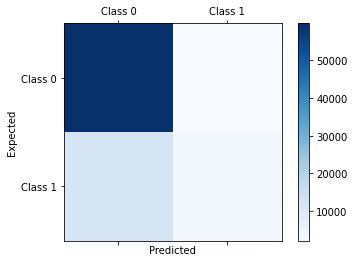

[0.        0.0353515 1.       ] [0.         0.25293667 1.        ] [2 1 0]


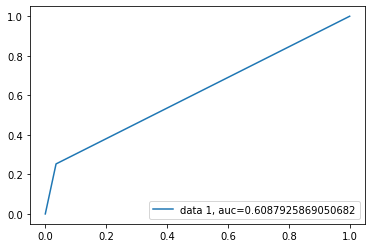

In [ ]:
model(raw_train, raw_train,KNeighborsClassifier(),'KNN', ['KNN', 'Raw'])

NearestCentroid(metric='euclidean', shrink_threshold=None)
[1 1 0 ... 1 0 1]
Accuracy: 33.17%
 f1  0.32188117128545835 
 recall 0.7856230847803881 
 precision 0.20240464481323706
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-290
Confusion matrix:
 [[13428 48493]
 [ 3358 12306]]


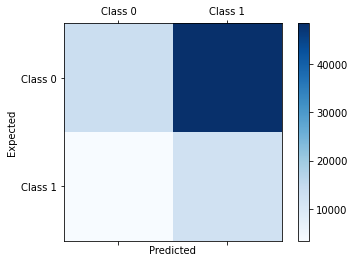

[0.         0.78314304 1.        ] [0.         0.78562308 1.        ] [2 1 0]


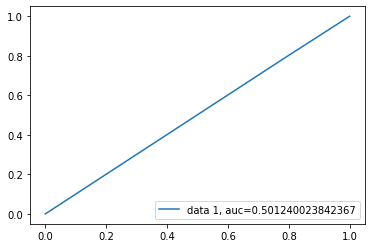

In [ ]:
model(raw_train, raw_train,NearestCentroid(),'NearestCentroid', ['NearestCentroid', 'Raw'])

RadiusNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                          metric_params=None, n_jobs=None, outlier_label=None,
                          p=2, radius=1.0, weights='uniform')
[0 0 0 ... 1 0 0]
Accuracy: 99.71%
 f1  0.9926725800231392 
 recall 0.9859550561797753 
 precision 0.9994822676676158
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-291
Confusion matrix:
 [[61913     8]
 [  220 15444]]


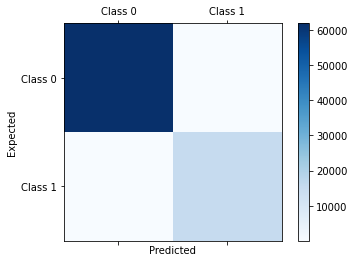

[0.0000000e+00 1.2919688e-04 1.0000000e+00] [0.         0.98595506 1.        ] [2 1 0]


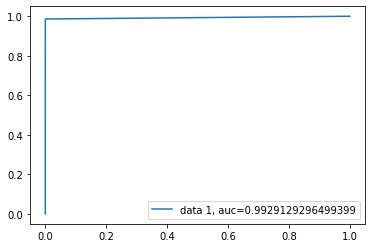

In [ ]:
model(raw_train, raw_train,RadiusNeighborsClassifier(),'RadiusNeighbors', ['RadiusNeighbors', 'Raw'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
[1 1 1 ... 0 0 0]
Accuracy: 73.59%
 f1  0.7284151733767745 
 recall 0.708465368945224 
 precision 0.7495210727969349
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-292
Confusion matrix:
 [[3372 1046]
 [1288 3130]]


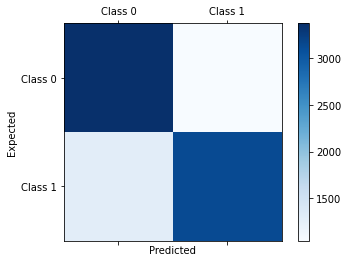

[0.         0.23675871 1.        ] [0.         0.70846537 1.        ] [2 1 0]


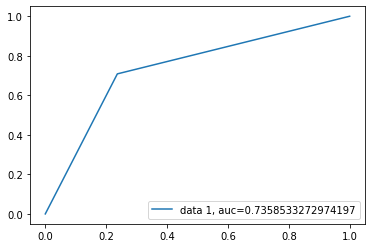

In [ ]:
model(Nearmiss_train, Nearmiss_test,KNeighborsClassifier(),'KNN', ['KNN', 'Nearmiss'])

NearestCentroid(metric='euclidean', shrink_threshold=None)
[0 0 0 ... 0 0 0]
Accuracy: 65.19%
 f1  0.4694722318040704 
 recall 0.30805794477138976 
 precision 0.986231884057971
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-297
Confusion matrix:
 [[4399   19]
 [3057 1361]]


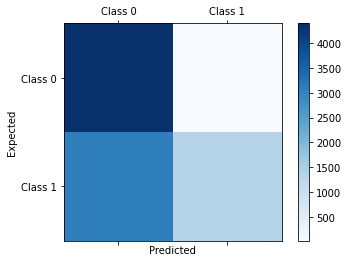

[0.         0.00430059 1.        ] [0.         0.30805794 1.        ] [2 1 0]


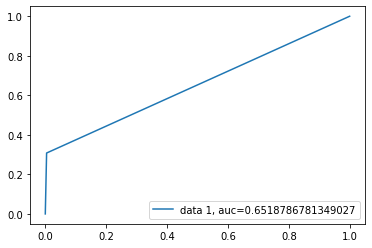

In [ ]:
model(Nearmiss_train, Nearmiss_test,NearestCentroid(),'NearestCentroid', ['NearestCentroid', 'Nearmiss'])

RadiusNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                          metric_params=None, n_jobs=None, outlier_label=1, p=2,
                          radius=1.0, weights='uniform')
[1 1 0 ... 1 1 1]
Accuracy: 52.59%
 f1  0.6776452481723739 
 recall 0.9966047985513807 
 precision 0.5133496560568963
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-304
Confusion matrix:
 [[ 244 4174]
 [  15 4403]]


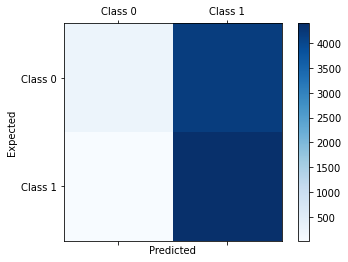

[0.         0.94477139 1.        ] [0.        0.9966048 1.       ] [2 1 0]


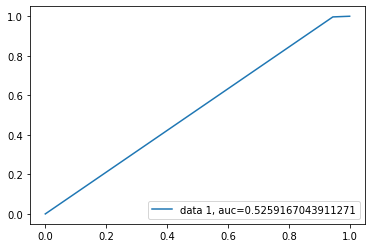

In [ ]:
model(Nearmiss_train, Nearmiss_test,RadiusNeighborsClassifier(outlier_label = 1),'RadiusNeighbors', ['RadiusNeighbors', 'Nearmiss'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
[0 1 1 ... 0 0 1]
Accuracy: 53.89%
 f1  0.5106796706468568 
 recall 0.4811909533352419 
 precision 0.544018643190057
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-293
Confusion matrix:
 [[10421  7044]
 [ 9061  8404]]


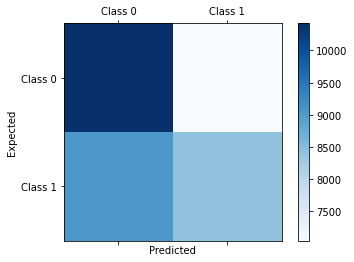

[0.         0.40332093 1.        ] [0.         0.48119095 1.        ] [2 1 0]


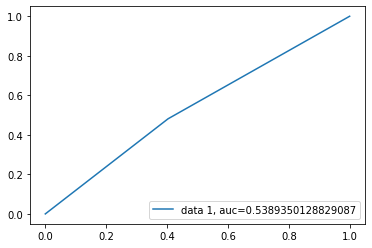

In [ ]:
model(ROS_train, ROS_test,KNeighborsClassifier(),'KNN', ['KNN', 'ROS'])

NearestCentroid(metric='euclidean', shrink_threshold=None)
[1 1 1 ... 0 1 1]
Accuracy: 49.85%
 f1  0.6097012098660903 
 recall 0.7833953621528772 
 precision 0.49905164867230817
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-298
Confusion matrix:
 [[ 3731 13734]
 [ 3783 13682]]


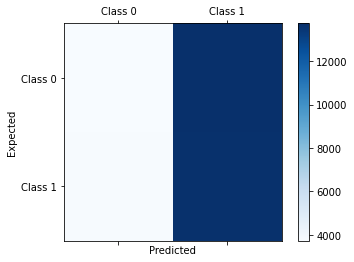

[0.         0.78637275 1.        ] [0.         0.78339536 1.        ] [2 1 0]


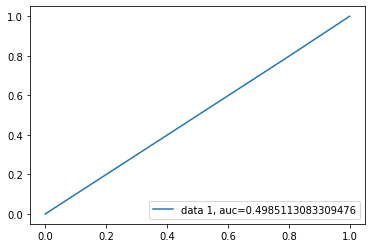

In [ ]:
model(ROS_train, ROS_test,NearestCentroid(),'NearestCentroid', ['NearestCentroid', 'ROS'])

RadiusNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                          metric_params=None, n_jobs=None, outlier_label=1, p=2,
                          radius=1.0, weights='uniform')
[1 1 1 ... 1 1 1]
Accuracy: 52.81%
 f1  0.6766834703124694 
 recall 0.9876324076724878 
 precision 0.5146497195369376
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-305
Confusion matrix:
 [[ 1198 16267]
 [  216 17249]]


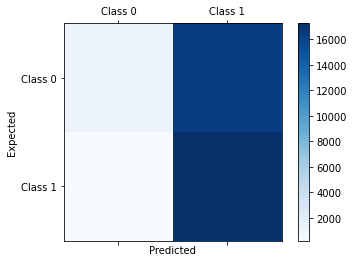

[0.         0.93140567 1.        ] [0.         0.98763241 1.        ] [2 1 0]


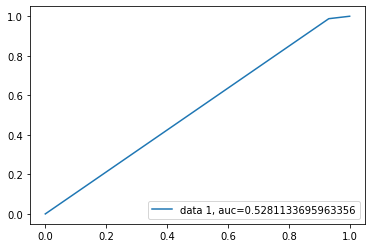

In [ ]:
model(ROS_train, ROS_test,RadiusNeighborsClassifier(outlier_label = 1),'RadiusNeighbors', ['RadiusNeighbors', 'ROS'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
[0 1 0 ... 1 1 1]
Accuracy: 51.51%
 f1  0.5174006081765965 
 recall 0.5199185151652331 
 precision 0.5149069715310468
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-294
Confusion matrix:
 [[2254 2164]
 [2121 2297]]


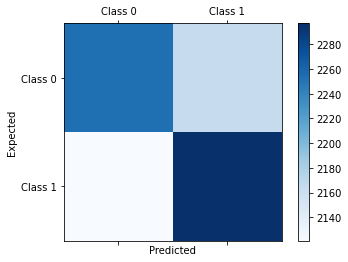

[0.        0.4898144 1.       ] [0.         0.51991852 1.        ] [2 1 0]


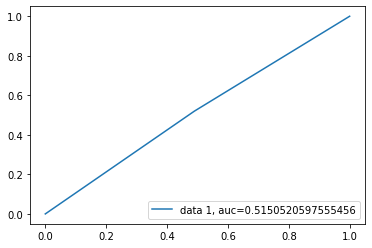

In [ ]:
model(RUS_train, RUS_test,KNeighborsClassifier(),'KNN', ['KNN', 'RUS'])

NearestCentroid(metric='euclidean', shrink_threshold=None)
[1 1 1 ... 1 1 1]
Accuracy: 49.81%
 f1  0.6088720345709498 
 recall 0.781349026708918 
 precision 0.49877185377835576
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-299
Confusion matrix:
 [[ 949 3469]
 [ 966 3452]]


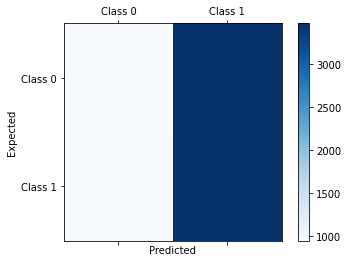

[0.         0.78519692 1.        ] [0.         0.78134903 1.        ] [2 1 0]


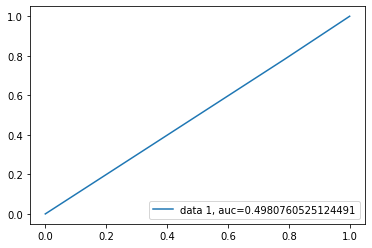

In [ ]:
model(RUS_train, RUS_test,NearestCentroid(),'NearestCentroid', ['NearestCentroid', 'RUS'])

RadiusNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                          metric_params=None, n_jobs=None, outlier_label=1, p=2,
                          radius=1.0, weights='uniform')
[1 1 1 ... 1 1 1]
Accuracy: 50.76%
 f1  0.6693015125028503 
 recall 0.9966047985513807 
 precision 0.5038333905481176
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-306
Confusion matrix:
 [[  82 4336]
 [  15 4403]]


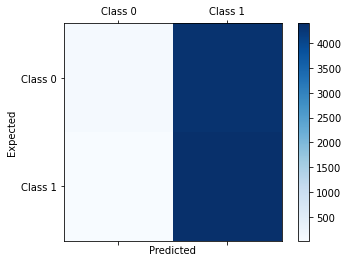

[0.         0.98143957 1.        ] [0.        0.9966048 1.       ] [2 1 0]


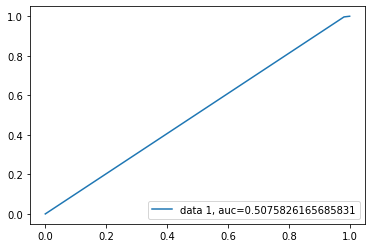

In [ ]:
model(RUS_train, RUS_test,RadiusNeighborsClassifier(outlier_label = 1),'RadiusNeighbors', ['RadiusNeighbors', 'RUS'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
[0 0 1 ... 0 1 1]
Accuracy: 53.94%
 f1  0.47908299866131193 
 recall 0.42364604912696063 
 precision 0.5512129380053908
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-295
Confusion matrix:
 [[8854 4662]
 [7790 5726]]


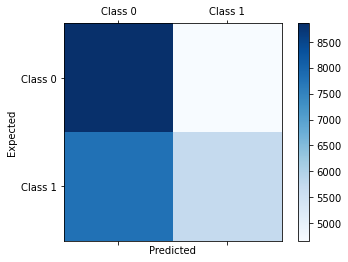

[0.         0.34492453 1.        ] [0.         0.42364605 1.        ] [2 1 0]


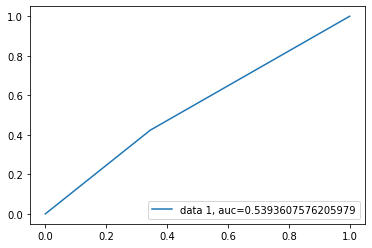

In [ ]:
model(SMOTETomek_train, SMOTETomek_test,KNeighborsClassifier(),'KNN', ['KNN', 'SMOTETomek'])

NearestCentroid(metric='euclidean', shrink_threshold=None)
[1 1 1 ... 1 1 1]
Accuracy: 49.90%
 f1  0.6099078341013825 
 recall 0.7833678603137023 
 precision 0.4993397472175061
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-300
Confusion matrix:
 [[ 2900 10616]
 [ 2928 10588]]


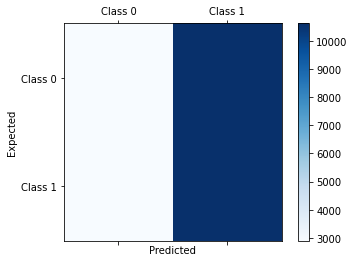

[0.         0.78543948 1.        ] [0.         0.78336786 1.        ] [2 1 0]


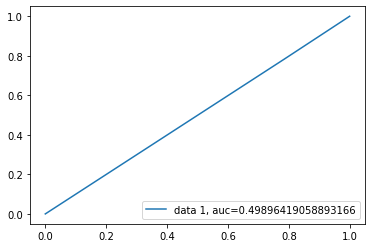

In [ ]:
model(SMOTETomek_train, SMOTETomek_test,NearestCentroid(),'NearestCentroid', ['NearestCentroid', 'SMOTETomek'])

RadiusNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                          metric_params=None, n_jobs=None, outlier_label=1, p=2,
                          radius=1.0, weights='uniform')
[1 1 1 ... 1 1 1]
Accuracy: 52.98%
 f1  0.6795734704681237 
 recall 0.9972625036993193 
 precision 0.5153902038007112
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-307
Confusion matrix:
 [[  842 12674]
 [   37 13479]]


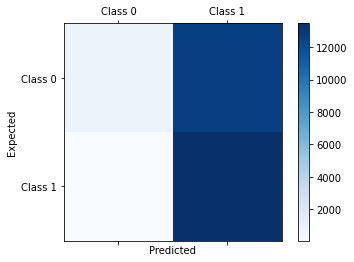

[0.         0.93770346 1.        ] [0.        0.9972625 1.       ] [2 1 0]


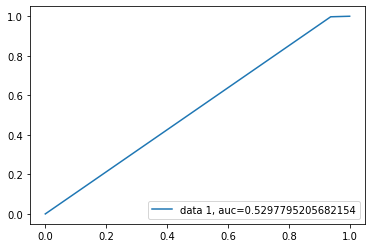

In [ ]:
model(SMOTETomek_train, SMOTETomek_test,RadiusNeighborsClassifier(outlier_label = 1),'RadiusNeighbors', ['RadiusNeighbors', 'SMOTETomek'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
[1 0 1 ... 0 1 1]
Accuracy: 53.45%
 f1  0.4824491614422557 
 recall 0.43383699633699635 
 precision 0.5433302272238549
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-296
Confusion matrix:
 [[11094  6371]
 [ 9892  7580]]


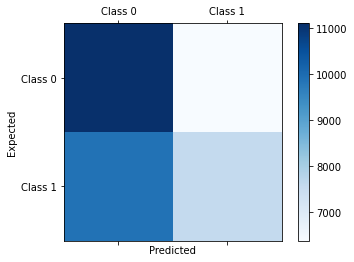

[0.         0.36478672 1.        ] [0.       0.433837 1.      ] [2 1 0]


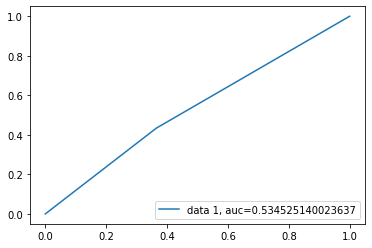

In [ ]:
model(Adasyn_train, Adasyn_test,KNeighborsClassifier(),'KNN', ['KNN', 'Adasyn'])

NearestCentroid(metric='euclidean', shrink_threshold=None)
[1 1 1 ... 1 1 1]
Accuracy: 49.80%
 f1  0.6092555869967246 
 recall 0.7825091575091575 
 precision 0.49881425809040825
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-301
Confusion matrix:
 [[ 3728 13737]
 [ 3800 13672]]


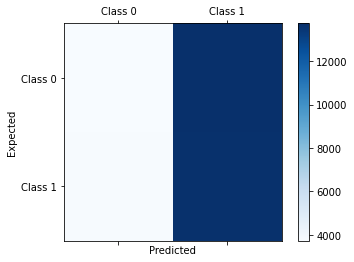

[0.         0.78654452 1.        ] [0.         0.78250916 1.        ] [2 1 0]


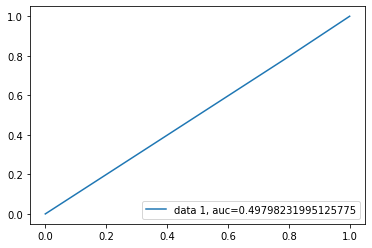

In [ ]:
model(Adasyn_train, Adasyn_test,NearestCentroid(),'NearestCentroid', ['NearestCentroid', 'Adasyn'])

RadiusNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                          metric_params=None, n_jobs=None, outlier_label=1, p=2,
                          radius=1.0, weights='uniform')
[1 1 1 ... 1 1 1]
Accuracy: 53.30%
 f1  0.6809284499110266 
 recall 0.9965086996336996 
 precision 0.5171532955119256
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-308
Confusion matrix:
 [[ 1209 16256]
 [   61 17411]]


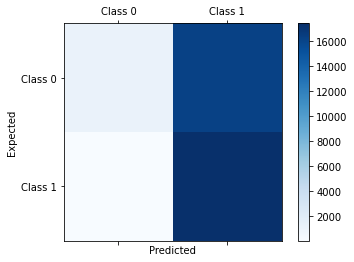

[0.         0.93077584 1.        ] [0.        0.9965087 1.       ] [2 1 0]


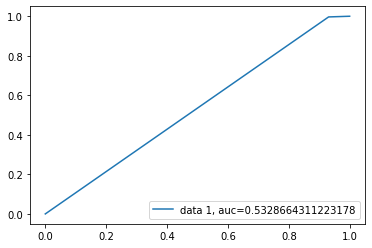

In [ ]:
model(Adasyn_train, Adasyn_test,RadiusNeighborsClassifier(outlier_label=1),'RadiusNeighbors', ['RadiusNeighbors', 'Adasyn'])

Literatura:
Marcin Szeliga, Data Science i uczenie maszynowe

https://scikit-learn.org/stable/modules/neighbors.html

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html#sklearn.neighbors.NearestCentroid

https://pl.wikipedia.org/wiki/Centroid

